# DeezerEurope

In [8]:
import scipy.stats as ss
import scipy.stats
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import warnings

import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import ChebConv, GCNConv, GATConv
from torch_geometric.datasets import DeezerEurope
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx

device = torch.device('cuda')

warnings.filterwarnings('ignore')

# I) Dataset : Deezer Europe

https://snap.stanford.edu/data/feather-deezer-social.html


In [9]:
dataset = DeezerEurope(root='data/DeezerEurope', transform=NormalizeFeatures())
data = dataset[0]
print(data)

Data(x=[28281, 128], edge_index=[2, 185504], y=[28281])


In [10]:
# Afficher quelques statistiques
print(f"Nombre total de nœuds : {data.num_nodes}")
print(f"Nombre total d'arêtes : {data.num_edges}")
print(f"Nombre de caractéristiques par nœud : {data.num_node_features}")
print(f"Nombre de classes : {dataset.num_classes}")

Nombre total de nœuds : 28281
Nombre total d'arêtes : 185504
Nombre de caractéristiques par nœud : 128
Nombre de classes : 2


Il est important de noter qu'il n'est pas nécessaire de recréer un graphe, car nous avons pu importer directement les données sous forme de graphes, ce qui évite ainsi le travail de constrcution de données sous forme de graphe.

### Les noeuds 

Nombre total de nœuds : 28 281 \
Explication : Le graphe contient 28 281 utilisateurs distincts de Deezer. Chaque nœud représente un utilisateur.

### Les arêtes

Nombre total d'arêtes : 185 504 \
Explication : Le graphe contient 185 504 relations d'amitié entre les utilisateurs. Chaque arête représente une connexion entre deux utilisateurs, indiquant qu'ils sont amis.

### Les features
Nombre de features par nœud : 128 \
Explication : Chaque utilisateur (nœud) est décrit par un vecteur de 128 caractéristiques. Ces caractéristiques peuvent représenter diverses informations, comme les préférences musicales, les interactions sociales, ou d'autres attributs dérivés du profil de l'utilisateur.

### Les classes

Nombre de classes : 2 \
Explication : Les utilisateurs sont classés en deux catégories. La nature exacte de ces catégories dépend de l'objectif de la tâche de classification, par exemple, distinguer les utilisateurs en fonction de leur comportement musical ou leur activité sur la plateforme.

### 1) Représentation du graphe

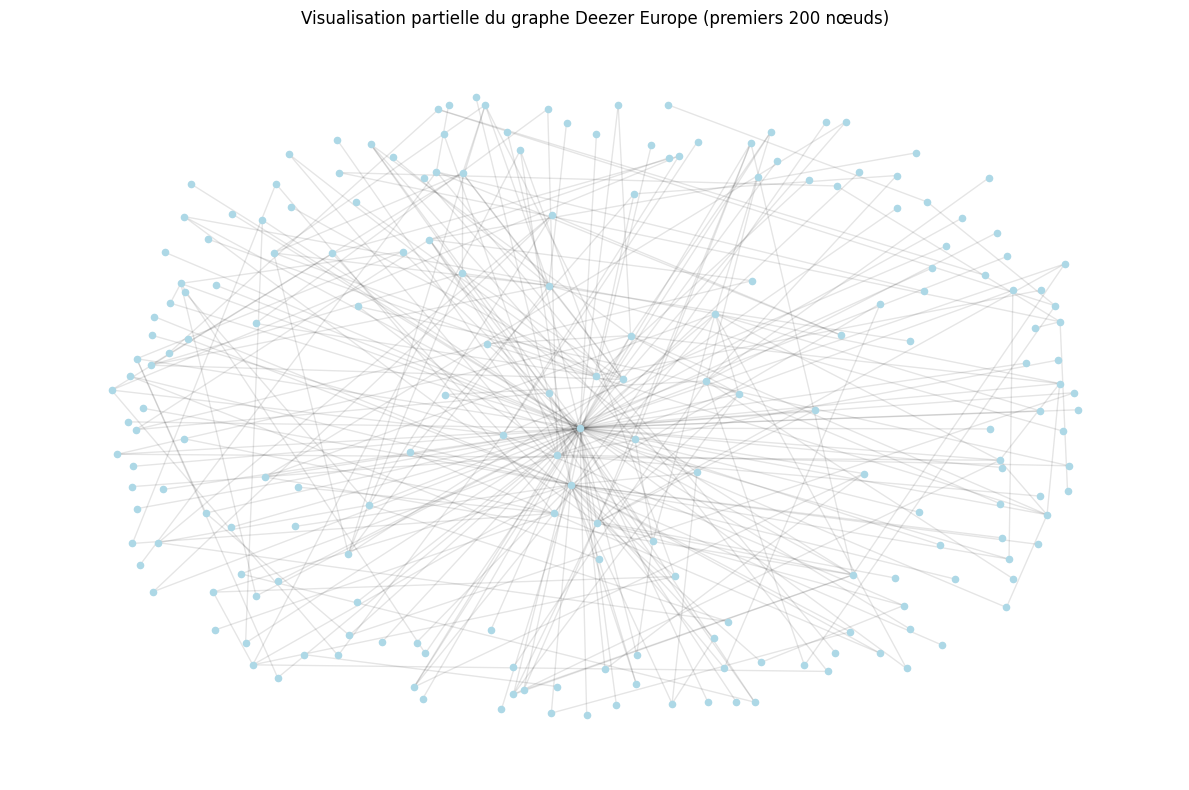

In [13]:
G = nx.Graph()
edge_index = data.edge_index.numpy()
G.add_edges_from(edge_index.T.tolist())  

degree_centrality = nx.degree_centrality(G)

subset_size = 200
subset_nodes = list(G.nodes())[:subset_size]
H = G.subgraph(subset_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(H, k=0.5, iterations=20) 

nx.draw_networkx_nodes(H, pos, node_size=20, node_color='lightblue')
nx.draw_networkx_edges(H, pos, alpha=0.1)

plt.title(f"Visualisation partielle du graphe Deezer Europe (premiers {subset_size} nœuds)")
plt.axis('off')
plt.tight_layout()
plt.show()


### 2) Un exemple de la composition du graphe

In [14]:
num_nodes = data.num_nodes
num_edges = data.num_edges // 2  # Dividido por 2 porque las aristas son bidireccionales
num_features = data.num_node_features
num_classes = data.y.max().item() + 1

print(f'Nombre total de nœuds : {num_nodes}')
print(f'Nombre total d\'arêtes : {num_edges}')
print(f'Nombre de caractéristiques par nœud : {num_features}')
print(f'Nombre de classes : {num_classes}')

node_index = torch.randint(0, num_nodes, (1,)).item()  
node_features = data.x[node_index]
node_class = data.y[node_index]

print(f'\nExemple de nœud:')
print(f'Index du nœud : {node_index}')
print(f'Caractéristiques du nœud : {node_features}')
print(f'Classe du nœud : {node_class}')

Nombre total de nœuds : 28281
Nombre total d'arêtes : 92752
Nombre de caractéristiques par nœud : 128
Nombre de classes : 2

Exemple de nœud:
Index du nœud : 23553
Caractéristiques du nœud : tensor([0.0079, 0.0095, 0.0097, 0.0074, 0.0057, 0.0066, 0.0120, 0.0100, 0.0069,
        0.0089, 0.0054, 0.0047, 0.0076, 0.0083, 0.0062, 0.0100, 0.0058, 0.0095,
        0.0062, 0.0041, 0.0147, 0.0069, 0.0107, 0.0076, 0.0091, 0.0054, 0.0147,
        0.0146, 0.0045, 0.0094, 0.0083, 0.0068, 0.0044, 0.0057, 0.0046, 0.0070,
        0.0135, 0.0055, 0.0065, 0.0046, 0.0140, 0.0073, 0.0103, 0.0114, 0.0130,
        0.0062, 0.0116, 0.0070, 0.0135, 0.0059, 0.0061, 0.0085, 0.0055, 0.0145,
        0.0066, 0.0054, 0.0060, 0.0065, 0.0026, 0.0120, 0.0122, 0.0073, 0.0138,
        0.0057, 0.0056, 0.0027, 0.0071, 0.0050, 0.0078, 0.0149, 0.0076, 0.0029,
        0.0093, 0.0000, 0.0051, 0.0063, 0.0076, 0.0114, 0.0071, 0.0140, 0.0057,
        0.0079, 0.0102, 0.0149, 0.0052, 0.0044, 0.0147, 0.0045, 0.0049, 0.0070,
        0

# II. Split ensemble de train et test

En premier lieu, il faut split les données en train et test comme ce n'est pas fait dans ce cas. Comme l'objectif des modèles testées est la prédiction de la classe binaire

In [15]:
data = dataset[0]

num_nodes = data.num_nodes
indices = np.random.permutation(num_nodes)
train_ratio = 0.8
train_size = int(train_ratio * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
test_mask[indices[train_size:]] = True

data.train_mask = train_mask
data.test_mask = test_mask



Data(x=[28281, 128], edge_index=[2, 185504], y=[28281], train_mask=[28281], test_mask=[28281])


# Classification : filtres de convolutions testés

- Chebyshev à travers ChebNet : "Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering"
- GATConv : "Graph Attention Networks"
- GCNConv : "Semi-Supervised Classification with Graph Convolutional Networks"

### ChebNet

In [16]:
class ChebNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K):
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K)
        self.conv2 = ChebConv(hidden_channels, out_channels, K)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

in_channels = dataset.num_features
hidden_channels = 64
out_channels = dataset.num_classes
K = 3  

model = ChebNet(in_channels, hidden_channels, out_channels, K)
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

ChebNet(
  (conv1): ChebConv(128, 64, K=3, normalization=sym)
  (conv2): ChebConv(64, 2, K=3, normalization=sym)
)


### GCNNet

In [17]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


### GATNet

In [18]:
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [19]:
def train(model, data, criterion, optimizer, epochs=200):
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            acc = test(model, data)
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')
    return test(model, data)

def test(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc


In [20]:
def train(model, data, criterion, optimizer, epochs=200):
    losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            acc = test(model, data)
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')
            losses.append(loss.item())
            accuracies.append(acc)
    
    return losses, accuracies

def test(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

Training ChebNet...
Epoch: 010, Loss: 0.6627, Test Accuracy: 0.6134
Epoch: 020, Loss: 0.6292, Test Accuracy: 0.6367
Epoch: 030, Loss: 0.6187, Test Accuracy: 0.6378
Epoch: 040, Loss: 0.6150, Test Accuracy: 0.6435
Epoch: 050, Loss: 0.6121, Test Accuracy: 0.6433
Epoch: 060, Loss: 0.6099, Test Accuracy: 0.6443
Epoch: 070, Loss: 0.6087, Test Accuracy: 0.6442
Epoch: 080, Loss: 0.6079, Test Accuracy: 0.6459
Epoch: 090, Loss: 0.6063, Test Accuracy: 0.6463
Epoch: 100, Loss: 0.6059, Test Accuracy: 0.6456
Epoch: 110, Loss: 0.6055, Test Accuracy: 0.6461
Epoch: 120, Loss: 0.6050, Test Accuracy: 0.6445
Epoch: 130, Loss: 0.6046, Test Accuracy: 0.6456
Epoch: 140, Loss: 0.6041, Test Accuracy: 0.6449
Epoch: 150, Loss: 0.6036, Test Accuracy: 0.6454
Epoch: 160, Loss: 0.6032, Test Accuracy: 0.6457
Epoch: 170, Loss: 0.6029, Test Accuracy: 0.6465
Epoch: 180, Loss: 0.6031, Test Accuracy: 0.6463
Epoch: 190, Loss: 0.6029, Test Accuracy: 0.6461
Epoch: 200, Loss: 0.6025, Test Accuracy: 0.6470
Epoch: 210, Loss: 0.

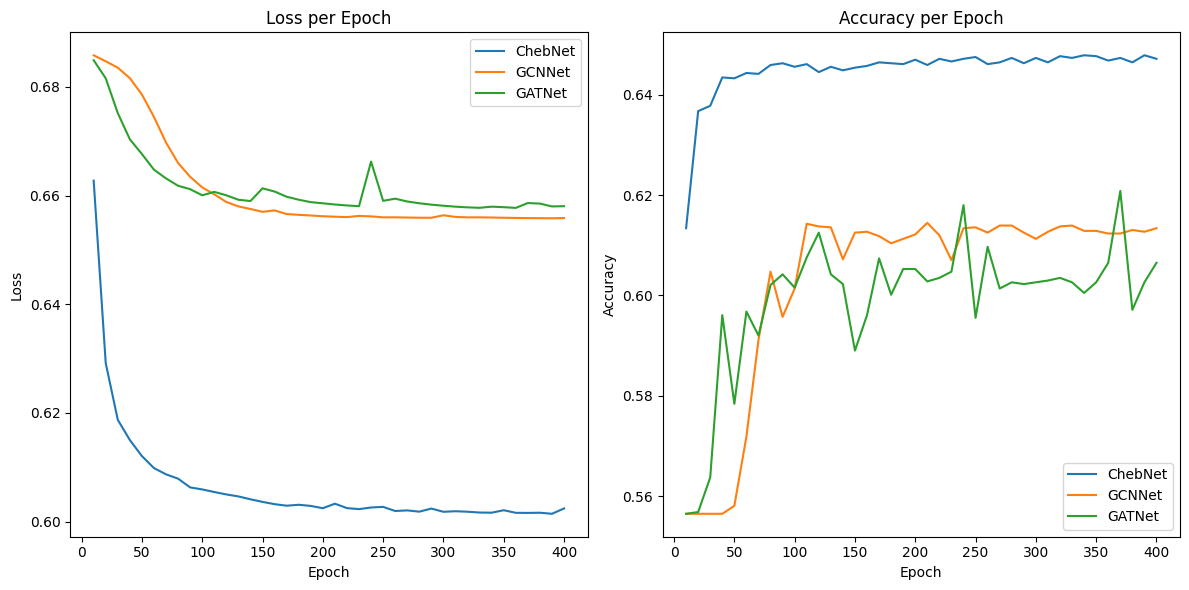

     Model  Test Accuracy  Time (seconds)
0  ChebNet       0.647163      253.197758
1   GCNNet       0.613399       76.280685
2   GATNet       0.606505      702.836305


In [23]:
models = {
    'ChebNet': ChebNet(in_channels=dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes, K=3),
    'GCNNet': GCNNet(in_channels=dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes),
    'GATNet': GATNet(in_channels=dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes)
}

results = {}
epochs = 400

for name, model in models.items():
    print(f'Training {name}...')
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    start_time = time.time()
    losses, accuracies = train(model, data, criterion, optimizer, epochs)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    
    results[name] = {
        'losses': losses,
        'accuracies': accuracies,
        'time': elapsed_time
    }

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for name, result in results.items():
    plt.plot(range(10, epochs + 1, 10), result['losses'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
for name, result in results.items():
    plt.plot(range(10, epochs + 1, 10), result['accuracies'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

results_df = pd.DataFrame.from_dict({
    'Model': [name for name in results],
    'Test Accuracy': [results[name]['accuracies'][-1] for name in results],
    'Time (seconds)': [results[name]['time'] for name in results]
})

print(results_df)